In [1]:
import sys
sys.path.insert(0 , '/home/arpit/study/ML/github')

In [2]:
import mglearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
#In this we will solve a bike rental problem
#The question is give time and data of the week , we have to predict how many will rent the bike
#importing the data set
citibike = mglearn.datasets.load_citibike()

In [7]:
citibike.head()
#The data is resampled into 3 hours interval to obtain the main trend

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

Text(0,0.5,'Rentals')

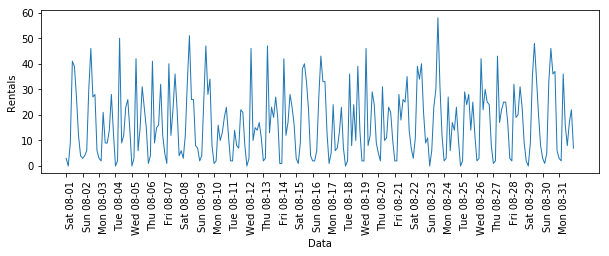

In [19]:
#now visulaizing the data
plt.figure(figsize = (10 , 3))
xticks = pd.date_range(start = citibike.index.min() , end = citibike.index.max() , freq = 'D')
plt.xticks(xticks  ,xticks.strftime("%a %m-%d"), rotation = 90, ha = 'left')
plt.plot(citibike , linewidth =1)
plt.xlabel("Data")
plt.ylabel("Rentals")
#this is a visulaize the data
#we can clearly distinguish between the day and night feature
#The pattern for week days and week ends also seem to be very different
#We will use the first 184 rental points as the training set
#And the remaining as the test set
#Only feature that we are using as per now is the date and time 
#Input feature is date and time and output is number of rentals


In [46]:
#Extract the target values
y = citibike.values                     #this is to use the citibike values , the axes are removed
#Now we are going to extract the feature
X_ = citibike.index.strftime("%s").astype("int")
X = np.asarray(X_)
X = X.reshape(-1 , 1)

range(1, 4)

In [51]:
#Now we define a function to build the model , split data into training and test set and then visualize the result
#using the starting 184 as the training point
n_train = 184
def eval_of_features(features , target , regressor):
    #Splitting the data into training and test set
    X_train , X_test = features[:n_train] , features[n_train:]
    y_train , y_test = target[:n_train] , target[n_train:]
    
    regressor.fit(X_train , y_train)
    print("Test score : " , regressor.score(X_test, y_test))
    
    #plotting the data
    y_pred_test = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    plt.figure(figsize = (10 , 3))
    plt.xticks(range(0 , len(X) , 8) , xticks.strftime("%a %m-%d") , rotation = 90 , ha = 'left')
    
    plt.plot(range(n_train) , y_train , label = "train")
    plt.plot(range(n_train , len(y_test) + n_train) , y_test , '-' , label = 'test')
    plt.plot(range(n_train) , y_pred_train , '--' ,label = "Training prediction" , )
    plt.plot(range(n_train , len(y_test) + n_train) , y_pred_test , '--' , label = "Predictio test")
    
    plt.legend(loc = (1.01 , 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test score :  -0.035486463625959086


<Figure size 432x288 with 0 Axes>

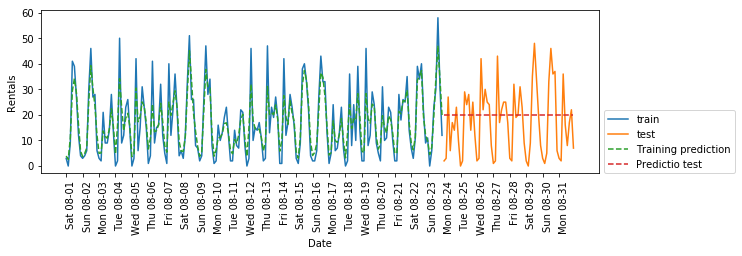

In [53]:
#Now using the random forest model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100 , random_state = 0)
plt.figure()
eval_of_features(X , y , regressor)
#as we can see the predictions are straight in the case of test case
#Because random forest cannot make prediction out of range
#The prediction for the training set is good but for test set it is very bad having a R2 score of -0.03
#This means we learned nothing
#So trees can not be used with such features
#The value that is predicted outside the range is the predicted value of the closest point in the training set
#So we are going to add two features time and day of the weak
#We are going to drop the current features


Test score :  0.5995775993305429


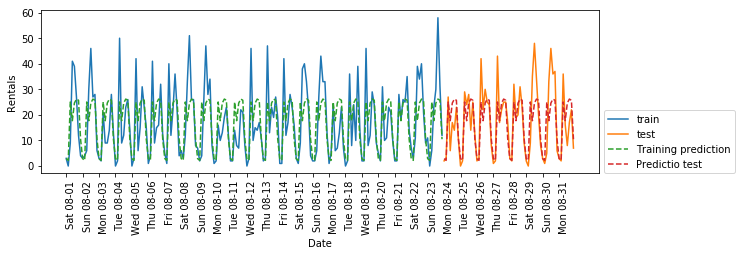

In [57]:
#We are going to first only the hour
X_hour_ = citibike.index.hour
X_hour = np.asarray(X_hour_).reshape(-1 , 1)
eval_of_features(X_hour , y , regressor)                #we are using the random forest here
#R2 is much better , but the pattern misses the weekly pattern
#So we are going to include the weak feature as well


Test score :  0.8419488587966025


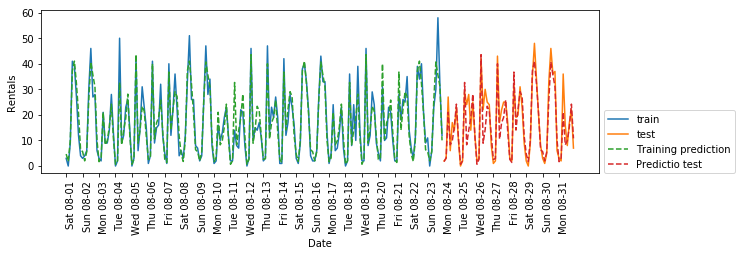

In [61]:
X_temp = np.asarray(citibike.index.dayofweek).reshape(-1 , 1)
X_hour_week = np.hstack([X_temp , X_hour])
eval_of_features(X_hour_week, y , regressor)
#this is the model that predicts the behaviour by considering both the time and day of the week
#It is leaning the mean number of rentals for each combination of week and day
#This does not require a very complex model so let's use linear model

Test score :  0.13204157262163152


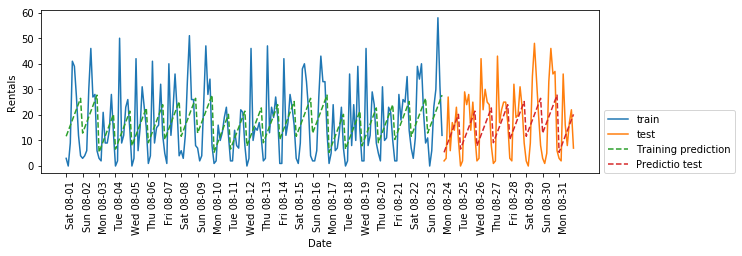

In [63]:
from sklearn.linear_model import LinearRegression
eval_of_features(X_hour_week , y , LinearRegression())
#linear regression is behaving very bad
#since there are categorical features it is better to use onehotencoding

In [66]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_enc = enc.fit_transform(X_hour_week).toarray()

Test score :  0.6117263223071611


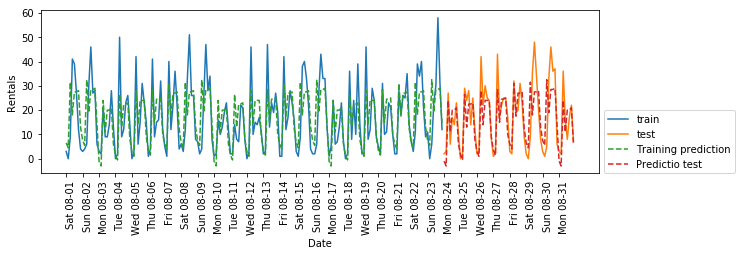

In [69]:
#evaluating the model now
eval_of_features(X_hour_week_enc , y , LinearRegression())
#the performance is nuch improved
#So never use categorical features as continuous features

In [75]:
#now we are going to use ridge with polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly_transform = PolynomialFeatures(degree = 2 , interaction_only = True  , include_bias = False)
print("Shape of X_hour_week_enc : " , X_hour_week_enc.shape)
X_hour_week_onhot = poly_transform.fit_transform(X_hour_week_enc)
#interaction_only true means pure features are not going to be included

print("X_hour_week_hot : " , X_hour_week_onhot.shape)

Shape of X_hour_week_enc :  (248, 15)
X_hour_week_hot :  (248, 120)


Test score :  0.8451706357968556


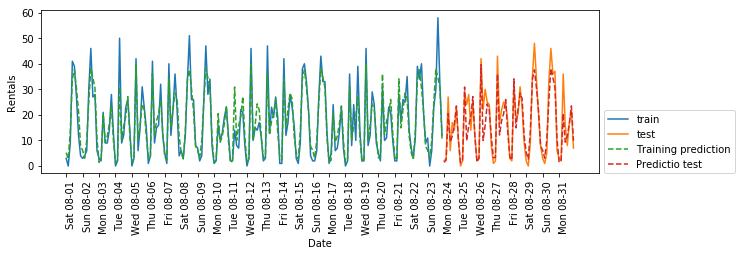

In [78]:
from sklearn.linear_model import Ridge
lr = Ridge()
eval_of_features(X_hour_week_onhot , y ,lr)
#this performs close to the Random forest model

In [82]:
#plotting the coef_ of the linear model
hour = ["%02d:00" % i for i in range(0 , 24 , 3)]
hour

['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']

In [83]:
day = ["Mon", "Tue", "Wed" , "Thu" , "Fri" , "Sat" , "Sun"]
day

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [87]:
feature = day + hour
feature

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00']

In [90]:
features_poly = poly_transform.get_feature_names(feature)
features_poly

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00',
 'Mon Tue',
 'Mon Wed',
 'Mon Thu',
 'Mon Fri',
 'Mon Sat',
 'Mon Sun',
 'Mon 00:00',
 'Mon 03:00',
 'Mon 06:00',
 'Mon 09:00',
 'Mon 12:00',
 'Mon 15:00',
 'Mon 18:00',
 'Mon 21:00',
 'Tue Wed',
 'Tue Thu',
 'Tue Fri',
 'Tue Sat',
 'Tue Sun',
 'Tue 00:00',
 'Tue 03:00',
 'Tue 06:00',
 'Tue 09:00',
 'Tue 12:00',
 'Tue 15:00',
 'Tue 18:00',
 'Tue 21:00',
 'Wed Thu',
 'Wed Fri',
 'Wed Sat',
 'Wed Sun',
 'Wed 00:00',
 'Wed 03:00',
 'Wed 06:00',
 'Wed 09:00',
 'Wed 12:00',
 'Wed 15:00',
 'Wed 18:00',
 'Wed 21:00',
 'Thu Fri',
 'Thu Sat',
 'Thu Sun',
 'Thu 00:00',
 'Thu 03:00',
 'Thu 06:00',
 'Thu 09:00',
 'Thu 12:00',
 'Thu 15:00',
 'Thu 18:00',
 'Thu 21:00',
 'Fri Sat',
 'Fri Sun',
 'Fri 00:00',
 'Fri 03:00',
 'Fri 06:00',
 'Fri 09:00',
 'Fri 12:00',
 'Fri 15:00',
 'Fri 18:00',
 'Fri 21:00',
 'Sat Sun',
 'Sat 00:00',
 'Sat 03:00',
 'Sat 06:00',
 'Sat 09:0

In [92]:
feature_nonzero = np.array(features_poly)[lr.coef_ != 0]
feature_nonzero

array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', '00:00', '03:00',
       '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', 'Mon 00:00',
       'Mon 03:00', 'Mon 06:00', 'Mon 09:00', 'Mon 12:00', 'Mon 15:00',
       'Mon 18:00', 'Mon 21:00', 'Tue 00:00', 'Tue 03:00', 'Tue 06:00',
       'Tue 09:00', 'Tue 12:00', 'Tue 15:00', 'Tue 18:00', 'Tue 21:00',
       'Wed 00:00', 'Wed 03:00', 'Wed 06:00', 'Wed 09:00', 'Wed 12:00',
       'Wed 15:00', 'Wed 18:00', 'Wed 21:00', 'Thu 00:00', 'Thu 03:00',
       'Thu 06:00', 'Thu 09:00', 'Thu 12:00', 'Thu 15:00', 'Thu 18:00',
       'Thu 21:00', 'Fri 00:00', 'Fri 03:00', 'Fri 06:00', 'Fri 09:00',
       'Fri 12:00', 'Fri 15:00', 'Fri 18:00', 'Fri 21:00', 'Sat 00:00',
       'Sat 03:00', 'Sat 06:00', 'Sat 09:00', 'Sat 12:00', 'Sat 15:00',
       'Sat 18:00', 'Sat 21:00', 'Sun 00:00', 'Sun 03:00', 'Sun 06:00',
       'Sun 09:00', 'Sun 12:00', 'Sun 15:00', 'Sun 18:00', 'Sun 21:00'],
      dtype='<U11')

In [94]:
coef_nonzero = lr.coef_[lr.coef_ != 0]
coef_nonzero

array([ -4.16724739,  -1.59581882,  -0.52439024,  -0.06010453,
         1.22560976,   2.26367831,   2.85827291, -11.69389764,
       -12.11122047,   8.61318898,  -0.07972441,   5.36909449,
         7.24311024,   7.63681102,  -4.9773622 ,   0.71826731,
         2.03125943,  -0.51204766,  -2.99236262,  -6.07897679,
        -3.2344886 ,   3.47023581,   2.43086573,  -1.96030412,
        -0.647312  ,   7.30938092,  -4.92093404,  -4.50754822,
        -2.91306003,   4.54166438,   1.5022943 ,  -2.76387555,
        -0.95088343,  15.00580949,  -5.97450547,  -5.56111965,
         1.03336854,  -1.76190705,   0.44872287,  -1.61208984,
        -1.04909771,  10.9075952 ,  -4.32271976,  -4.15933393,
        -3.31484574,   1.88987867,   1.60050859,  -2.57637555,
        -3.26338343,   7.69330949,  -2.78700547,  -1.12361965,
         3.47086854,   0.92559295,  -1.11377713,  -1.9119221 ,
        -3.97806383, -13.75759139,  15.19673932,  13.4376842 ,
         4.3384716 ,  -4.97648903,  -6.08515045,  -1.58

Text(0,0.5,'Feature magnitude')

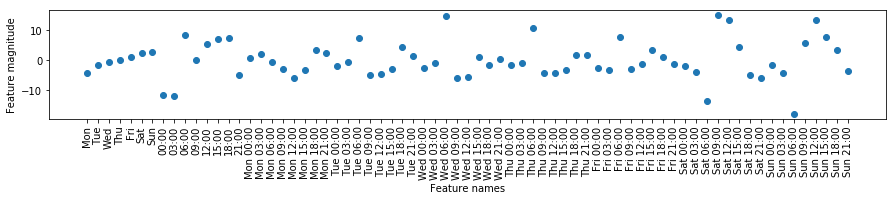

In [97]:
plt.figure(figsize = (15 , 2))
plt.plot(coef_nonzero , 'o')
plt.xticks(np.arange(len(coef_nonzero)) , feature_nonzero , rotation = 90)
plt.xlabel('Feature names')
plt.ylabel("Feature magnitude")